# Exercise 5: Regularized Linear Regression and Bias vs. Variance

In this exercise, we will implement regularized linear regression and use it to study models with different bias-variance properties.

In the first half of the exercise, we will implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir. 

In the second half, we will go through some diagnostics of debugging learning algorithms and examine the effects of bias vs. variance.

## Loading and Visualizing the Data

In [1]:
% Load Training, Cross-Validation and Test Data
% You will have X, y, Xval, yval, Xtest, ytest in your environment
load ('data/ex5data1.mat');

% m = Number of examples
m = size(X, 1);



We will begin by visualizing the dataset containing historical records on the change in the water level, x, and the amount of water flowing out of the dam, y.
This dataset is divided into three parts:
* A training set that we will use to train our model: `X, y`
* A cross validation set for determining the regularization parameter: `Xval, yval`
* A test set for evaluating performance. These are "unseen" examples which our model did *not see* during training: `Xtest, ytest`

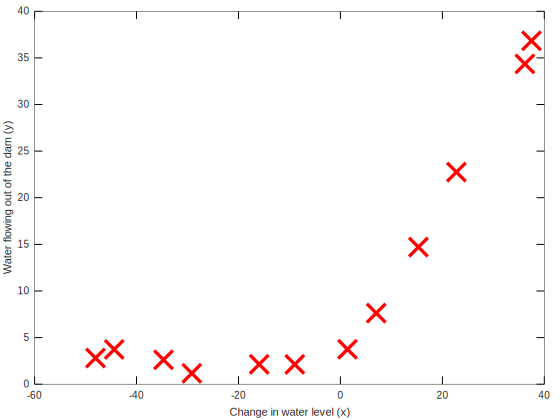

In [2]:
% Plot training data
plot(X, y, 'rx', 'MarkerSize', 10, 'LineWidth', 1.5);
xlabel('Change in water level (x)');
ylabel('Water flowing out of the dam (y)');

## Regularized linear regression: cost function and gradients

Regularized linear regression has the following cost function
$$ J(\theta) = \frac{1}{2m} \sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})^2 + \underbrace{\frac{\lambda}{2m}(\sum_{i=1}^{n} \theta_i^2)}_{\text{Regularization term}} $$ 
with
$$ h_\theta(x) = \theta^T x, \theta = (\theta_0,...\theta_n) $$ 

Note that we are not regularizing $ \theta_0 $.

The gradients of our cost functions are given by the following formulae:

$$
\frac{\delta J(\theta)}{\delta \theta_j} 
    =  \frac{1}{m} \sum_{i=1}^{m}(h_\theta(x^{(i)}))-y^{(i)})*x^{(i)} , j = 0 
$$
$$
\frac{\delta J(\theta)}{\delta \theta_j} 
    =  \frac{1}{m} \sum_{i=1}^{m}(h_\theta(x^{(i)}))-y^{(i)})*x^{(i)} + \frac{\lambda}{m} \theta_j , j = 1, 1,...,n
$$

In [3]:
function result = h(theta, x)
    result = (theta'*x')';
end

In [4]:
function [J, grad] = linearRegCostFunction(X, y, theta, lambda)
%LINEARREGCOSTFUNCTION Compute cost and gradient for regularized linear 
%regression with multiple variables
%   [J, grad] = LINEARREGCOSTFUNCTION(X, y, theta, lambda) computes the 
%   cost of using theta as the parameter for linear regression to fit the 
%   data points in X and y. Returns the cost in J and the gradient in grad

    % Initialize some useful values
    m = length(y); % number of training examples

    % You need to return the following variables correctly 
    J = 0;
    grad = zeros(size(theta));

    % We can use matrix multiplication to computer our sums
    sum1 = (h(theta, X)-y)' * (h(theta, X)-y);

    % Special case: don't regularize theta(1), therefore only use theta(2:end)
    reg1 = theta(2:end)'*theta(2:end);
    
    J = 0.5 * (1/m) * sum1 + 0.5 * (lambda/m) * reg1;

    % Again, the sums for the gradient is computed using a matrix mutliplication
    sum2 = X' * (h(theta, X) - y);
    reg2 = lambda/m * theta;
    % Special case: don't regularize theta(1)
    reg2(1) = 0;
    grad = 1/m * sum2 + reg2;


    grad = grad(:);
end

Testing our cost function and its gradients:

In [5]:
theta = [1 ; 1];
J = linearRegCostFunction([ones(m, 1) X], y, theta, 1);

fprintf(['Cost at theta = [1 ; 1]: %f '...
         '\n(this value should be about 303.993192)\n'], J);

Cost at theta = [1 ; 1]: 303.993192 
(this value should be about 303.993192)


In [6]:
theta = [1 ; 1];
[J, grad] = linearRegCostFunction([ones(m, 1) X], y, theta, 1);

fprintf(['Gradient at theta = [1 ; 1]:  [%f; %f] '...
         '\n(this value should be about [-15.303016; 598.250744])\n'], ...
         grad(1), grad(2));

Gradient at theta = [1 ; 1]:  [-15.303016; 598.250744] 
(this value should be about [-15.303016; 598.250744])


## Training

As before, we are training our linear regression.
Note, that this won't work very well, because the data is not linear!

In [7]:
function [theta] = trainLinearReg(X, y, lambda)
%TRAINLINEARREG Trains linear regression given a dataset (X, y) and a
%regularization parameter lambda
%   [theta] = TRAINLINEARREG (X, y, lambda) trains linear regression using
%   the dataset (X, y) and regularization parameter lambda. Returns the
%   trained parameters theta.
%

    % Initialize Theta
    initial_theta = zeros(size(X, 2), 1); 

    % Create "short hand" for the cost function to be minimized
    costFunction = @(t) linearRegCostFunction(X, y, t, lambda);

    % Now, costFunction is a function that takes in only one argument
    options = optimset('MaxIter', 200, 'GradObj', 'on');

    % Minimize using fmincg
    theta = fmincg(costFunction, initial_theta, options);

end

In [8]:
%  Train linear regression with lambda = 0
lambda = 0;
[theta] = trainLinearReg([ones(m, 1) X], y, lambda);



Iteration     6 | Cost: 2.237391e+01


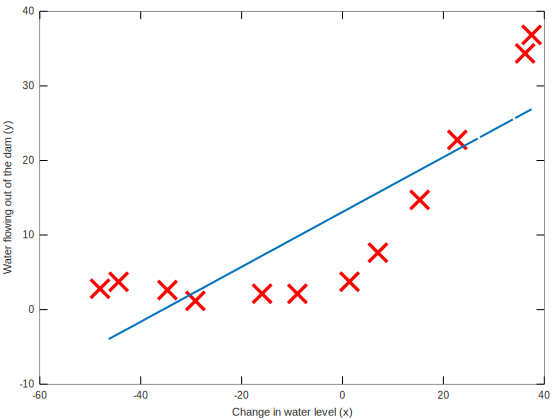

In [9]:
%  Plot fit over the data
plot(X, y, 'rx', 'MarkerSize', 10, 'LineWidth', 1.5);
xlabel('Change in water level (x)');
ylabel('Water flowing out of the dam (y)');
hold on;
plot(X, [ones(m, 1) X]*theta, '--', 'LineWidth', 2);
hold off;

## Bias and Variance

An important concept in machine learning is the bias-variance tradeoff. Models with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data.

To illustrate these concepts, we will train our linear regression (without regularization) with training sets of different sizes and evaluate how well the trained parameters work on both the training set and the cross evaluation set.

In [10]:
function [error_train, error_val] = ...
    learningCurve(X, y, Xval, yval, lambda)
%LEARNINGCURVE Generates the train and cross validation set errors needed 
%to plot a learning curve
%   [error_train, error_val] = ...
%       LEARNINGCURVE(X, y, Xval, yval, lambda) returns the train and
%       cross validation set errors for a learning curve. In particular, 
%       it returns two vectors of the same length - error_train and 
%       error_val. Then, error_train(i) contains the training error for
%       i examples (and similarly for error_val(i)).
%
%   In this function, we will compute the train and test errors for
%   dataset sizes from 2 up to m. In practice, when working with larger
%   datasets, we might want to do this in larger intervals.
%

    % Number of training examples
    m = size(X, 1);

    % We need to return these values correctly
    error_train = zeros(m, 1);
    error_val   = zeros(m, 1);

    % Compute train/cross validation errors using training examples 
    % X(1:i, :) and y(1:i), storing the result in 
    % error_train(i) and error_val(i)
    for i = 2:m
        Xtrain = X(1:i, :);
        ytrain = y(1:i);
        
        mtrain = i;
        [theta] = trainLinearReg([ones(mtrain, 1) Xtrain], ytrain, lambda);
        
        [err, grads] = linearRegCostFunction([ones(mtrain, 1) Xtrain], ytrain, theta, 0);
        error_train(i) = err;
        mval = size(Xval, 1);
        [err, grads] = linearRegCostFunction([ones(mval, 1) Xval], yval, theta, 0);    
        error_val(i) = err;   
    end
    
end

In [11]:
lambda = 0;
[error_train, error_val] = ...
    learningCurve([ones(m, 1) X], y, ...
                  [ones(size(Xval, 1), 1) Xval], yval, ...
                  lambda);

fprintf('# Training Examples\tTrain Error\tCross Validation Error\n');
for i = 2:m
    fprintf('  \t%d\t\t%f\t%f\n', i, error_train(i), error_val(i));
end

Iteration    48 | Cost: 9.121204e-30
Iteration    22 | Cost: 3.286595e+00
Iteration    10 | Cost: 2.842678e+00
Iteration     3 | Cost: 1.315405e+01
Iteration    13 | Cost: 1.944396e+01
Iteration     7 | Cost: 2.009852e+01
Iteration     4 | Cost: 1.817286e+01
Iteration    18 | Cost: 2.260941e+01
Iteration     8 | Cost: 2.326146e+01
Iteration    17 | Cost: 2.431725e+01
Iteration    44 | Cost: 2.237391e+01
# Training Examples	Train Error	Cross Validation Error
  	2		0.000000	110.300366
  	3		3.286595	45.010231
  	4		2.842678	48.368911
  	5		13.154049	35.865165
  	6		19.443963	33.829962
  	7		20.098522	31.970986
  	8		18.172859	30.862446
  	9		22.609405	31.135998
  	10		23.261462	28.936207
  	11		24.317250	29.551432
  	12		22.373906	29.433818


As we can see in the follwing diagram, the error on the training data slowly rises contantly, because our data does not fit very well to a linar regression. The validation error drops quickly (because we soon reach the best line to fit the data), but stays high (because our regression does not fit very well). 

This reflects a *high bias problem in the model* – the linear regression model is too simple and is unable to fit our dataset well.

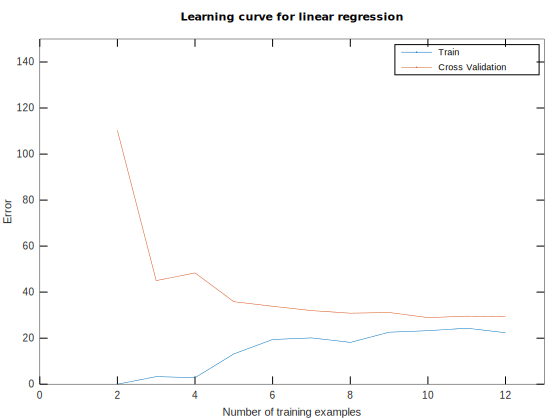

In [12]:
plot(2:m, error_train(2:m), 2:m, error_val(2:m));
title('Learning curve for linear regression')
legend('Train', 'Cross Validation')
xlabel('Number of training examples')
ylabel('Error')
axis([0 13 0 150])

## Polynomial regression

The problem with our linear model was that it was too simple for the data and resulted in underfitting (high bias). In this part of the exercise, you will address this problem by adding more features.
We could use polynomial regression. In this case our hypothesis has the form:

$$ h_0(x) = \theta_0 + \theta_1 * \underbrace{x}_{=x_1} + \theta_2 * \underbrace{x^2}_{=:x_2} + ... \theta_p * \underbrace{x^p}_{=:x_p} $$

To make this work, we need to create the polynomial features $ x_1,...,X_p $ and append them to our data set $ X $. 

In [13]:
function [X_poly] = polyFeatures(X, p)
%POLYFEATURES Maps X (1D vector) into the p-th power
%   [X_poly] = POLYFEATURES(X, p) takes a data matrix X (size m x 1) and
%   maps each example into its polynomial features where
%   X_poly(i, :) = [X(i) X(i).^2 X(i).^3 ...  X(i).^p];
%


    % You need to return the following variables correctly.
    X_poly = zeros(numel(X), p);

    % Given a vector X, return a matrix X_poly where the p-th 
    % column of X contains the values of X to the p-th 
    
    for i = 1:numel(X)
        for j = 1:p
            X_poly(i, j) = X(i).^j;
        end
    end
end

It is often a good idea to normalize the features before applying a learning algorithm. The following function des exactly that: it normalizes a set of data such, that the mean value of each feature is 0 and the standard deviation is 1.0.

In [14]:
function [X_norm, mu, sigma] = featureNormalize(X)
%FEATURENORMALIZE Normalizes the features in X 
%   FEATURENORMALIZE(X) returns a normalized version of X where
%   the mean value of each feature is 0 and the standard deviation
%   is 1. This is often a good preprocessing step to do when
%   working with learning algorithms.

    mu = mean(X); % returns a row vector with the means for each column
    X_norm = bsxfun(@minus, X, mu);

    sigma = std(X_norm); % returns a row vector with the std dev for each column
    X_norm = bsxfun(@rdivide, X_norm, sigma);
end

In [15]:
p = 8;

% Map X onto Polynomial Features and Normalize
X_poly = polyFeatures(X, p);
[X_poly, mu, sigma] = featureNormalize(X_poly);  % Normalize
X_poly = [ones(m, 1), X_poly];                   % Add Ones

% Map X_poly_test and normalize (using mu and sigma)
X_poly_test = polyFeatures(Xtest, p);
X_poly_test = bsxfun(@minus, X_poly_test, mu);
X_poly_test = bsxfun(@rdivide, X_poly_test, sigma);
X_poly_test = [ones(size(X_poly_test, 1), 1), X_poly_test];         % Add Ones

% Map X_poly_val and normalize (using mu and sigma)
X_poly_val = polyFeatures(Xval, p);
X_poly_val = bsxfun(@minus, X_poly_val, mu);
X_poly_val = bsxfun(@rdivide, X_poly_val, sigma);
X_poly_val = [ones(size(X_poly_val, 1), 1), X_poly_val];           % Add Ones

fprintf('Normalized Training Example 1:\n');
fprintf('  %f  \n', X_poly(1, :));

Normalized Training Example 1:
  1.000000  
  -0.362141  
  -0.755087  
  0.182226  
  -0.706190  
  0.306618  
  -0.590878  
  0.344516  
  -0.508481  


In [16]:
function plotFit(min_x, max_x, mu, sigma, theta, p)
%PLOTFIT Plots a learned polynomial regression fit over an existing figure.
%Also works with linear regression.
%   PLOTFIT(min_x, max_x, mu, sigma, theta, p) plots the learned polynomial
%   fit with power p and feature normalization (mu, sigma).

% Hold on to the current figure
hold on;

% We plot a range slightly bigger than the min and max values to get
% an idea of how the fit will vary outside the range of the data points
x = (min_x - 15: 0.05 : max_x + 25)';

% Map the X values 
X_poly = polyFeatures(x, p);
X_poly = bsxfun(@minus, X_poly, mu);
X_poly = bsxfun(@rdivide, X_poly, sigma);

% Add ones
X_poly = [ones(size(x, 1), 1) X_poly];

% Plot
plot(x, X_poly * theta, '--', 'LineWidth', 2)

% Hold off to the current figure
hold off

end

Iteration   200 | Cost: 1.464727e-01


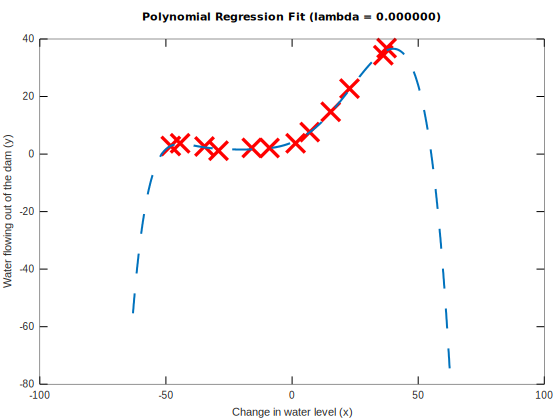

In [17]:
lambda = 0;
[theta] = trainLinearReg(X_poly, y, lambda);

% Plot training data and fit
figure(1);
plot(X, y, 'rx', 'MarkerSize', 10, 'LineWidth', 1.5);
plotFit(min(X), max(X), mu, sigma, theta, p);
xlabel('Change in water level (x)');
ylabel('Water flowing out of the dam (y)');
title (sprintf('Polynomial Regression Fit (lambda = %f)', lambda));

From the figure above, we can see that the polynomial fit is able to follow the datapoints very well - thus, obtaining a low training error. 

However, the polynomial fit is very complex and even drops off at the extremes. This is an indicator that the polynomial regression model is overfitting the training data and will not generalize well.

To better understand the problems with the unregularized $(\lambda = 0)$ model, we can see that the learning curve (see below) shows the same effect where the training error is low, but the cross validation error is high. There is a gap between the training and cross validation errors, indicating a high variance problem.

Iteration     4 | Cost: 6.162976e-32
Iteration    46 | Cost: 8.545993e-31
Iteration    11 | Cost: 6.754622e-30
Iteration   200 | Cost: 2.165492e-12
Iteration   200 | Cost: 5.334133e-05
Iteration   200 | Cost: 2.902770e-02
Iteration   200 | Cost: 6.577899e-02
Iteration   200 | Cost: 1.539841e-01
Iteration   200 | Cost: 1.454790e-01
Iteration   200 | Cost: 1.658878e-01
Iteration   200 | Cost: 1.728451e-01


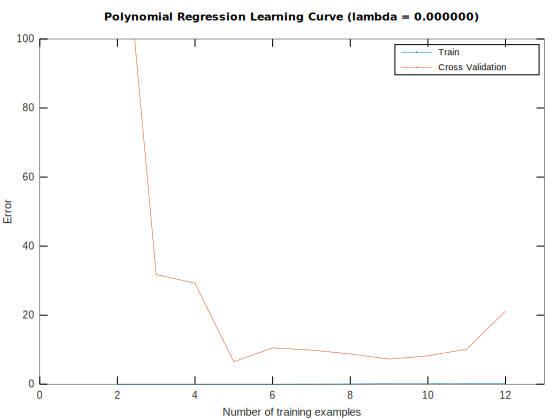

In [18]:
[error_train, error_val] = ...
    learningCurve(X_poly, y, X_poly_val, yval, lambda);
plot(2:m, error_train(2:m), 2:m, error_val(2:m));

title(sprintf('Polynomial Regression Learning Curve (lambda = %f)', lambda));
xlabel('Number of training examples')
ylabel('Error')
axis([0 13 0 100])
legend('Train', 'Cross Validation')

## The effects of regularization

In this section, we will get to observe how the regularization parameter affects the bias-variance of regularized polynomial regression.

Iteration    72 | Cost: 7.268148e+00


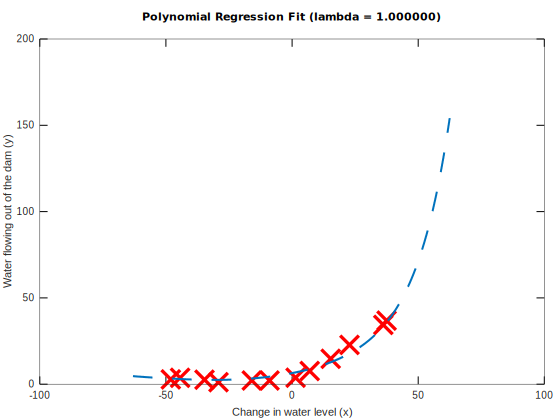

In [19]:
lambda = 1;
[theta] = trainLinearReg(X_poly, y, lambda);

% Plot training data and fit
figure(1);
plot(X, y, 'rx', 'MarkerSize', 10, 'LineWidth', 1.5);
plotFit(min(X), max(X), mu, sigma, theta, p);
xlabel('Change in water level (x)');
ylabel('Water flowing out of the dam (y)');
title (sprintf('Polynomial Regression Fit (lambda = %f)', lambda));

Iteration    41 | Cost: 7.269436e-02
Iteration    56 | Cost: 1.849879e+01
Iteration    70 | Cost: 1.457586e+01
Iteration    89 | Cost: 1.166072e+01
Iteration    68 | Cost: 1.011882e+01
Iteration    94 | Cost: 9.416317e+00
Iteration    81 | Cost: 8.256224e+00
Iteration    97 | Cost: 7.802076e+00
Iteration    12 | Cost: 7.064398e+00
Iteration    19 | Cost: 6.423784e+00
    fmincg at line 102 column 12
    trainLinearReg at line 19 column 11
    learningCurve at line 32 column 16
Iteration    97 | Cost: 7.268148e+00


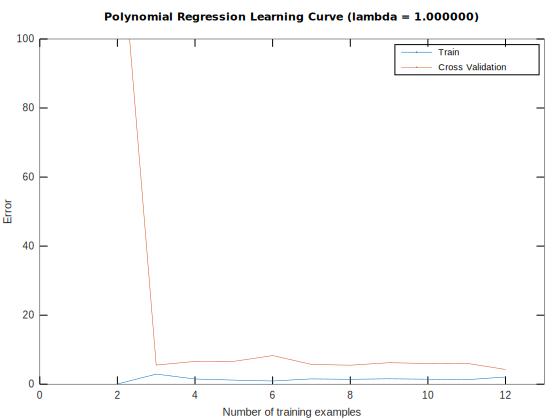

In [20]:
[error_train, error_val] = ...
    learningCurve(X_poly, y, X_poly_val, yval, lambda);
plot(2:m, error_train(2:m), 2:m, error_val(2:m));

title(sprintf('Polynomial Regression Learning Curve (lambda = %f)', lambda));
xlabel('Number of training examples')
ylabel('Error')
axis([0 13 0 100])
legend('Train', 'Cross Validation')

For $ \lambda = 1 $, you can see a polynomial fit that follows the data trend well and a learning curve showing that both the cross validation and training error converge to a relatively low value. This shows that the $ \lambda = 1 $ regularized polynomial regression model does not have the high- bias or high-variance problems. In effect, it achieves a good trade-off between bias and variance.

Iteration    25 | Cost: 6.673316e+01


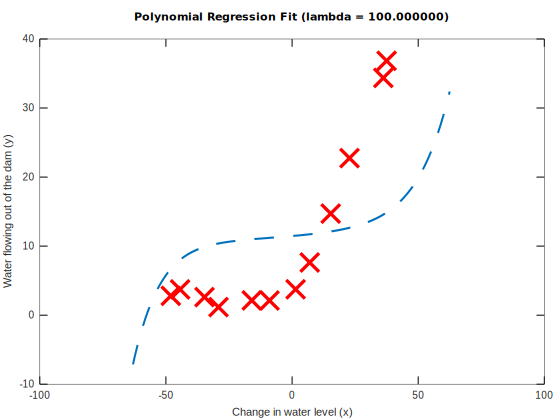

In [21]:
lambda = 100;
[theta] = trainLinearReg(X_poly, y, lambda);

% Plot training data and fit
figure(1);
plot(X, y, 'rx', 'MarkerSize', 10, 'LineWidth', 1.5);
plotFit(min(X), max(X), mu, sigma, theta, p);
xlabel('Change in water level (x)');
ylabel('Water flowing out of the dam (y)');
title (sprintf('Polynomial Regression Fit (lambda = %f)', lambda));

For $ \lambda = 100 $, we can see a polynomial fit that does not follow the data well. In this case, there is too much regularization and the model is unable to fit the training data.

Iteration    25 | Cost: 1.147779e-01
Iteration    37 | Cost: 1.127823e+02
Iteration    43 | Cost: 1.326203e+02
Iteration    34 | Cost: 1.173491e+02
Iteration    20 | Cost: 1.099213e+02
Iteration    31 | Cost: 9.427848e+01
Iteration    36 | Cost: 8.731906e+01
Iteration    26 | Cost: 8.108431e+01
Iteration    43 | Cost: 7.391554e+01
Iteration    38 | Cost: 6.765806e+01
Iteration    33 | Cost: 6.673316e+01


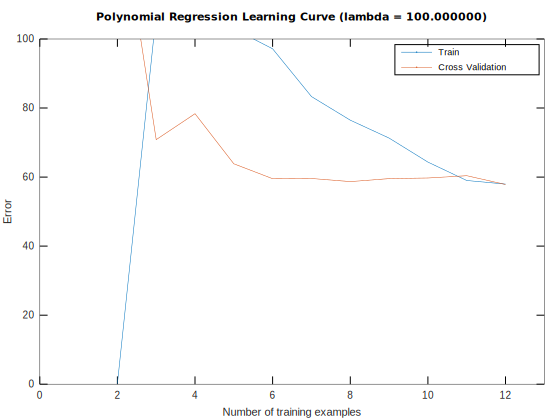

In [22]:
[error_train, error_val] = ...
    learningCurve(X_poly, y, X_poly_val, yval, lambda);
plot(2:m, error_train(2:m), 2:m, error_val(2:m));

title(sprintf('Polynomial Regression Learning Curve (lambda = %f)', lambda));
xlabel('Number of training examples')
ylabel('Error')
axis([0 13 0 100])
legend('Train', 'Cross Validation')

## Selecting a model with the cross validation set

From the previous parts of the exercise, we observed that the value of $\lambda$ can significantly affect the results of regularized polynomial regression on the training and cross validation set. In particular, a model without regularization $(\lambda= 0)$ fits the training set well, but does not generalize. Conversely, a model with too much regularization $(\lambda= 100)$ does not fit the training set and testing set well. A good choice of λ (e.g., $\lambda= 1$) can provide a good fit to the data.
In this section, we will implement an automated method to select the $\lambda$ parameter. Concretely, we will use the *cross validation* set to evaluate how good each $\lambda$ value is. After selecting the best $\lambda$ value using the cross validation set, we can then evaluate the model on the *test set* to estimate how well the model will perform on actual unseen data.

In [23]:
function [lambda_vec, error_train, error_val] = ...
    validationCurve(X, y, Xval, yval)
%VALIDATIONCURVE Generate the train and validation errors needed to
%plot a validation curve that we can use to select lambda
%   [lambda_vec, error_train, error_val] = ...
%       VALIDATIONCURVE(X, y, Xval, yval) returns the train
%       and validation errors (in error_train, error_val)
%       for different values of lambda. You are given the training set (X,
%       y) and validation set (Xval, yval).
%

    % Selected values of lambda (you should not change this)
    lambda_vec = [0 0.001 0.003 0.01 0.03 0.1 0.3 1 3 10]';

    % You need to return these variables correctly.
    error_train = zeros(length(lambda_vec), 1);
    error_val = zeros(length(lambda_vec), 1);

    m = size(X, 1);
    mval = size(Xval, 1);
    
    for i = 1:length(lambda_vec)
        lambda = lambda_vec(i);
        
        [theta] = trainLinearReg([ones(m, 1) X], y, lambda);
        
        [err, grads] = linearRegCostFunction([ones(m, 1) X], y, theta, 0);
        error_train(i) = err;

        [err, grads] = linearRegCostFunction([ones(mval, 1) Xval], yval, theta, 0);    
        error_val(i) = err;   
    end
end


Iteration   200 | Cost: 1.541337e-01
Iteration   200 | Cost: 2.029557e-01
Iteration   200 | Cost: 2.563817e-01
Iteration   200 | Cost: 3.860318e-01
    fmincg at line 102 column 12
    trainLinearReg at line 19 column 11
    validationCurve at line 25 column 16
Iteration   200 | Cost: 6.695862e-01
Iteration   200 | Cost: 1.443470e+00
Iteration   125 | Cost: 3.101591e+00
Iteration    82 | Cost: 7.268148e+00
Iteration    78 | Cost: 1.586769e+01
Iteration    33 | Cost: 3.337220e+01


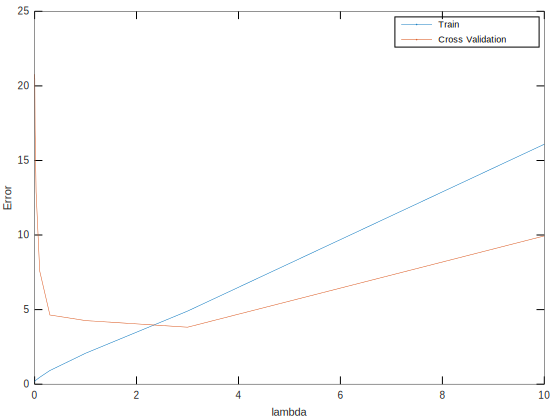

In [24]:
[lambda_vec, error_train, error_val] = ...
    validationCurve(X_poly, y, X_poly_val, yval);

close all;
plot(lambda_vec, error_train, lambda_vec, error_val);
legend('Train', 'Cross Validation');
xlabel('lambda');
ylabel('Error');

Let's pick the best value of $ \lambda $ (where the cross validation error is smallest) and see what we can achieve on the test set.

Iteration    38 | Cost: 1.586769e+01


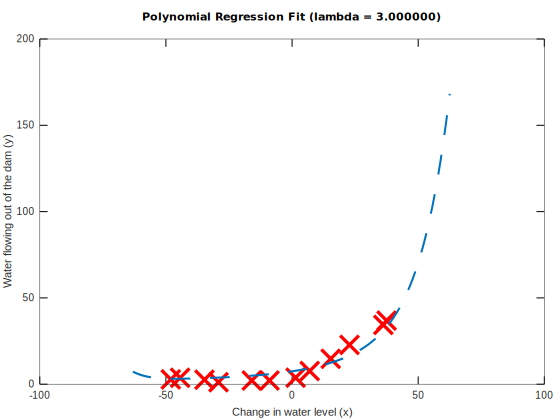

In [25]:
lambda = 3;
[theta] = trainLinearReg(X_poly, y, lambda);

% Plot training data and fit
figure(1);
plot(X, y, 'rx', 'MarkerSize', 10, 'LineWidth', 1.5);
plotFit(min(X), max(X), mu, sigma, theta, p);
xlabel('Change in water level (x)');
ylabel('Water flowing out of the dam (y)');
title (sprintf('Polynomial Regression Fit (lambda = %f)', lambda));



In [26]:
% Compute the error on the test data
err = linearRegCostFunction(X_poly_test, ytest, theta, 0)
% fprintf('Test error for lambda = 3: %f -- expected 3.8599\n', err);

err =  3.8599
